# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import yaml
import json
import gc
from tqdm import tqdm
import pickle
import os 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import torch

import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

from basin_volume import *

/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(jax.__version__)

0.4.38


# Tokenizer

In [3]:

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-14m")

In [4]:
tokenizer.eos_token_id = 0
tokenizer.pad_token_id = 1

# Model

In [5]:

model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-14m").to("cuda")

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [6]:
trained_params_t = torch.nn.utils.parameters_to_vector(model.parameters()).detach()

In [7]:
trained_params_j = jax.dlpack.from_dlpack(trained_params_t)

## (Counting params)

In [10]:
print(summarize(trained_params_j))
print(summarize(trained_params_t))


{'type': <class 'jaxlib.xla_extension.ArrayImpl'>, 'size': 14067712, 'info': {'shape': (14067712,), 'dtype': dtype('float32'), 'device': CudaDevice(id=0)}}
{'type': <class 'torch.Tensor'>, 'size': 14067712, 'info': {'shape': torch.Size([14067712]), 'dtype': torch.float32, 'device': device(type='cuda', index=0)}}


In [ ]:
# for name, p in model.named_parameters():
#     print(name, p.shape)
# print()

# sort by number of parameters and print
sorted_params = sorted(model.named_parameters(), key=lambda x: np.prod(x[1].shape))
# compute total number of parameters
total_params = sum(np.prod(p.shape) for name, p in sorted_params)
print(f"Total number of parameters: {total_params}")

# compute total embedding parameters
embedding_params = sum(np.prod(p.shape) for name, p in sorted_params if "embed" in name)
print(f"Total number of embedding parameters: {embedding_params}")
print(f"Total number of non-embedding parameters: {total_params - embedding_params}")

# for name, p in reversed(sorted_params):
#     print(f"{np.prod(p.shape) / total_params:.2%}", p.shape, name)

Total number of parameters: 14067712
Total number of embedding parameters: 12877824
Total number of non-embedding parameters: 1189888


# Dataset

In [8]:
with open("../data/val.jsonl", "r") as f:
    text_val = [json.loads(line)['text'] for line in f]

## (Sampling)

In [13]:
print(text_val[0])

Catalonia election: Puigdemont calls for talks with Spain Published duration 22 December 2017 Related Topics Catalonia independence protests

image copyright Reuters image caption "Now is the time for dialogue," said Carles Puigdemont

Catalonia's ousted leader, Carles Puigdemont, has called for new talks with Spain after separatist parties won a slim majority in a regional election.

He said he wanted the negotiations in Brussels, where he is living in self-imposed exile, or another EU country.

Spain's Prime Minister Mariano Rajoy later appeared to reject the idea.

He said he would hold talks with the head of the new Catalan government but that leader would have to take up their post in Catalonia itself.

He avoided naming Mr Puigdemont, adding that the winner of Thursday's election was Inés Arrimadas, the leader of the Citizens party, which wants Catalonia to remain a semi-autonomous part of Spain.

The Citizens party is now the region's biggest party. although pro-independence par

In [23]:
# sample from model

input_ids = tokenizer(text_val[:2], return_tensors="pt", padding=True, truncation=True, max_length=512)['input_ids']
logits = model.generate(input_ids.to("cuda"), 
                        max_new_tokens=512, 
                        do_sample=True,
                        temperature=0.7,
                        top_k=50,
                        top_p=0.95,
                        )
print(logits.shape)
print(tokenizer.decode(logits[0], skip_special_tokens=True))
print(tokenizer.decode(logits[1], skip_special_tokens=True))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([2, 1024])
Catalonia election: Puigdemont calls for talks with Spain Published duration 22 December 2017 Related Topics Catalonia independence protests

image copyright Reuters image caption "Now is the time for dialogue," said Carles Puigdemont

Catalonia's ousted leader, Carles Puigdemont, has called for new talks with Spain after separatist parties won a slim majority in a regional election.

He said he wanted the negotiations in Brussels, where he is living in self-imposed exile, or another EU country.

Spain's Prime Minister Mariano Rajoy later appeared to reject the idea.

He said he would hold talks with the head of the new Catalan government but that leader would have to take up their post in Catalonia itself.

He avoided naming Mr Puigdemont, adding that the winner of Thursday's election was Inés Arrimadas, the leader of the Citizens party, which wants Catalonia to remain a semi-autonomous part of Spain.

The Citizens party is now the region's biggest party. althoug

## (Padding token stuff)

In [145]:
n_seqs = 40
out = model(tokenizer(text_val[:n_seqs], return_tensors="pt", padding=True, truncation=True, max_length=1024)['input_ids'])

In [ ]:
n_seqs = 40
out = model(tokenizer(text_val[:n_seqs], return_tensors="pt", padding=True, truncation=True, max_length=1024)['input_ids'])

In [94]:
short_texts = [text_val[i] for i in indices+[0]]
out = model(tokenizer(short_texts, return_tensors="pt", padding=True, truncation=True, max_length=1024)['input_ids'])

In [95]:
out.logits.shape

torch.Size([41, 1024, 50304])

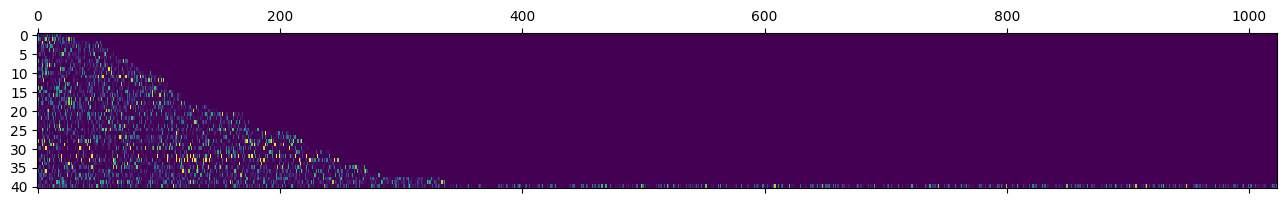

In [110]:
plt.matshow(tokenizer(short_texts, return_tensors="pt", padding=True, truncation=True, max_length=1024)['input_ids'].detach().numpy(), aspect='auto')

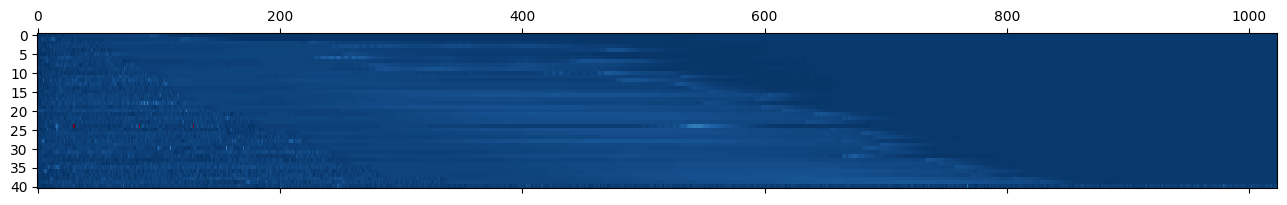

In [ ]:
plt.matshow(out.logits[:, :, 1].detach().numpy(), cmap='RdBu', aspect='auto')

In [156]:
lens[60]

715

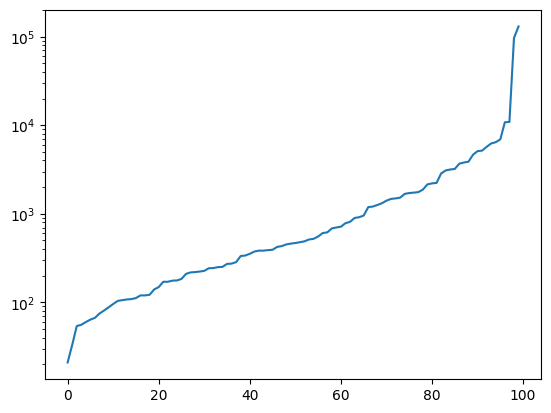

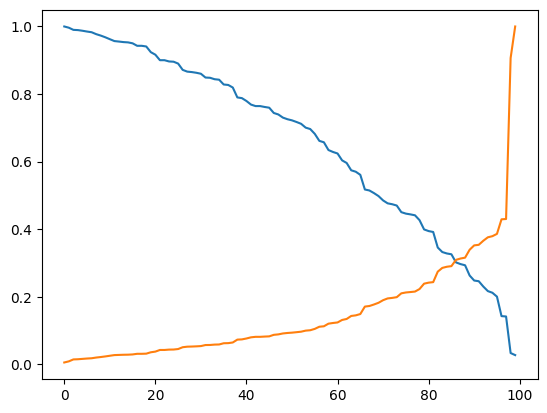

In [154]:
lens = sorted(map(lambda t: len(tokenizer(t)['input_ids']), text_val[:100]))
def frac_filled(lens, max_len):
    return sum(min(l, max_len) for l in lens) / (max_len * len(lens))
def frac_used(lens, max_len):
    return sum(min(l, max_len) for l in lens) / sum(lens)

plt.plot(lens)
plt.yscale('log')
plt.show()


plt.plot([frac_filled(lens, max_len) for max_len in lens])
plt.plot([frac_used(lens, max_len) for max_len in lens])
plt.show()

In [143]:
# get indices of shortest 40 sequences
indices = sorted(range(len(text_val[:100])), key=lambda i: len(tokenizer(text_val[i])['input_ids']))[:n_seqs]

In [144]:
summarize(out)

{'type': transformers.modeling_outputs.CausalLMOutputWithPast,
 'size': 2,
 'contents': [{'key': 'logits',
   'value': {'type': torch.Tensor,
    'size': 2111963136,
    'info': {'shape': torch.Size([41, 1024, 50304]), 'dtype': torch.float32}}},
  {'key': 'past_key_values',
   'value': {'type': tuple,
    'size': 6,
    'contents': [{'type': tuple,
      'size': 2,
      'contents': [{'type': torch.Tensor,
        'size': 5373952,
        'info': {'shape': torch.Size([41, 4, 1024, 32]),
         'dtype': torch.float32}},
       {'type': torch.Tensor,
        'size': 5373952,
        'info': {'shape': torch.Size([41, 4, 1024, 32]),
         'dtype': torch.float32}}]},
     {'type': tuple,
      'size': 2,
      'contents': [{'type': torch.Tensor,
        'size': 5373952,
        'info': {'shape': torch.Size([41, 4, 1024, 32]),
         'dtype': torch.float32}},
       {'type': torch.Tensor,
        'size': 5373952,
        'info': {'shape': torch.Size([41, 4, 1024, 32]),
         'dtype

## Val subset

In [9]:
n_seqs = 10
X_val_t = tokenizer(text_val[:n_seqs], return_tensors="pt", padding=True, truncation=True, max_length=1024)['input_ids'].to("cuda")
X_val_j = jax.dlpack.from_dlpack(X_val_t)

# Basins

## kl_fn etc

In [10]:
# https://github.com/EleutherAI/pythia/blob/main/models/14M/pythia-14m.yml
with open("../data/pythia-14m.yml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
l2_reg = config['weight-decay']
# TODO: determine if this is the correct train size
train_size = config['train-iters'] * config['train_micro_batch_size_per_gpu']
sigma_epoch = 1/jnp.sqrt(l2_reg * train_size)

In [11]:
sigma_params = jnp.sqrt(jnp.mean(trained_params_j**2))

In [12]:
print(sigma_epoch)  # way too small(?)
print(sigma_params)

0.001478281
0.32929182


In [13]:
def apply_fn(params, x, *, debug=False):
    # assign params to model
    params_t = torch.from_dlpack(params)
    torch.nn.utils.vector_to_parameters(params_t, model.parameters())
    if debug:
        print(f"{x.shape=}")
    return jax.dlpack.from_dlpack(model(x).logits.detach())

In [14]:
def make_kl_fn(probs_p, apply_fn, x, l2_reg, debug=False):
    def kl_fn(a, b):
        # [model_dim]
        params_q = a + b
        # x: [batch, seq_len] (input_ids)
        # [batch, seq_len, vocab_size]
        logits_q = apply_fn(params_q, x, debug=debug)
        # [batch, seq_len, vocab_size]
        logprobs_q = jax.nn.log_softmax(logits_q)
        if debug:
            print(f"{logprobs_q.shape=} {probs_p.shape=}")
        # [batch, seq_len]
        kl_all = optax.kl_divergence(logprobs_q, probs_p)
        mask = jax.dlpack.from_dlpack(x != tokenizer.pad_token_id)
        # scalar
        kl_term = jnp.mean(kl_all[mask])
        l2_term = 1/2 * l2_reg * jnp.sum(b**2)

        del logits_q, logprobs_q, kl_all, mask
        return kl_term + l2_term
    return kl_fn

def make_kl_fn_params(params_p, apply_fn, x, *, l2_reg, debug=False):
    logits_p = apply_fn(params_p, x, debug=debug)
    if debug:
        print(f"{logits_p.shape=}")
    probs_p = jax.nn.softmax(logits_p)
    if debug:
        print(f"{probs_p.shape=}")
    return make_kl_fn(probs_p, apply_fn, x, l2_reg=l2_reg, debug=debug)

## Experiments

### ADAM

In [43]:
type(model)

transformers.models.gpt_neox.modeling_gpt_neox.GPTNeoXForCausalLM

In [42]:
print(model.state_dict().keys())


odict_keys(['gpt_neox.embed_in.weight', 'gpt_neox.layers.0.input_layernorm.weight', 'gpt_neox.layers.0.input_layernorm.bias', 'gpt_neox.layers.0.post_attention_layernorm.weight', 'gpt_neox.layers.0.post_attention_layernorm.bias', 'gpt_neox.layers.0.attention.query_key_value.weight', 'gpt_neox.layers.0.attention.query_key_value.bias', 'gpt_neox.layers.0.attention.dense.weight', 'gpt_neox.layers.0.attention.dense.bias', 'gpt_neox.layers.0.mlp.dense_h_to_4h.weight', 'gpt_neox.layers.0.mlp.dense_h_to_4h.bias', 'gpt_neox.layers.0.mlp.dense_4h_to_h.weight', 'gpt_neox.layers.0.mlp.dense_4h_to_h.bias', 'gpt_neox.layers.1.input_layernorm.weight', 'gpt_neox.layers.1.input_layernorm.bias', 'gpt_neox.layers.1.post_attention_layernorm.weight', 'gpt_neox.layers.1.post_attention_layernorm.bias', 'gpt_neox.layers.1.attention.query_key_value.weight', 'gpt_neox.layers.1.attention.query_key_value.bias', 'gpt_neox.layers.1.attention.dense.weight', 'gpt_neox.layers.1.attention.dense.bias', 'gpt_neox.layers

In [36]:
# list /mnt/hdd-0/tiny-pythia/ckpts/pythia-14m/
sorted(os.listdir("/mnt/hdd-0/tiny-pythia/ckpts/pythia-14m/"))


['global_step0',
 'global_step1',
 'global_step1000',
 'global_step10000',
 'global_step100000',
 'global_step101000',
 'global_step102000',
 'global_step103000',
 'global_step104000',
 'global_step105000',
 'global_step106000',
 'global_step107000',
 'global_step108000',
 'global_step109000',
 'global_step11000',
 'global_step110000',
 'global_step111000',
 'global_step112000',
 'global_step113000',
 'global_step114000',
 'global_step115000',
 'global_step116000',
 'global_step117000',
 'global_step118000',
 'global_step119000',
 'global_step12000',
 'global_step120000',
 'global_step121000',
 'global_step122000',
 'global_step123000',
 'global_step124000',
 'global_step125000',
 'global_step126000',
 'global_step127000',
 'global_step128',
 'global_step128000',
 'global_step129000',
 'global_step13000',
 'global_step130000',
 'global_step131000',
 'global_step132000',
 'global_step133000',
 'global_step134000',
 'global_step135000',
 'global_step136000',
 'global_step137000',
 'globa

In [23]:
with open("/mnt/hdd-0/tiny-pythia/ckpts/pythia-14m/global_step256/mp_rank_00_model_states.pt", "rb") as f:
    states = torch.load(f)

/tmp/ipykernel_61413/2434520434.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(f)


In [45]:
print(states.keys())


dict_keys(['module', 'buffer_names', 'optimizer', 'param_shapes', 'lr_scheduler', 'data_sampler', 'random_ltd', 'sparse_tensor_module_names', 'skipped_steps', 'global_steps', 'global_samples', 'dp_world_size', 'mp_world_size', 'ds_config', 'ds_version', 'iteration', 'args', 'random_rng_state', 'np_rng_state', 'torch_rng_state', 'cuda_rng_state', 'rng_tracker_states'])


In [52]:
print(states['buffer_names'])


['sequential.2.attention.rotary_emb.inv_freq', 'sequential.3.attention.rotary_emb.inv_freq', 'sequential.4.attention.rotary_emb.inv_freq', 'sequential.5.attention.rotary_emb.inv_freq', 'sequential.6.attention.rotary_emb.inv_freq', 'sequential.7.attention.rotary_emb.inv_freq']


In [32]:
optstates = states['optimizer']['optimizer_state_dict']['state']
for k, v in optstates.items():
    print(k)
    print(v['exp_avg_sq'].shape)

0
torch.Size([14057472])
1
torch.Size([10240])


In [34]:
trained_params_j.shape, sum([v['exp_avg_sq'].shape[0] for v in optstates.values()])


((14067712,), 14067712)

In [27]:
# pretty print
print(json.dumps(list(states.keys()), indent=4))


[
    "module",
    "buffer_names",
    "optimizer",
    "param_shapes",
    "lr_scheduler",
    "data_sampler",
    "random_ltd",
    "sparse_tensor_module_names",
    "skipped_steps",
    "global_steps",
    "global_samples",
    "dp_world_size",
    "mp_world_size",
    "ds_config",
    "ds_version",
    "iteration",
    "args",
    "random_rng_state",
    "np_rng_state",
    "torch_rng_state",
    "cuda_rng_state",
    "rng_tracker_states"
]


### Naive

In [15]:
kl_fn = make_kl_fn_params(trained_params_j, apply_fn, X_val_t, l2_reg=0.)   

In [16]:
kl_fn(trained_params_j, 0.)

Array(-2.3063529e-09, dtype=float32)

In [17]:
CUTOFF = 1e-2

RESULTS = {} # estimates, props, mults, deltas, logabsint

In [44]:
result_size = 100

RESULTS['naive'] = get_estimates_vectorized_gauss(result_size, 
                                                  batch_size=1,
                                                  sigma=sigma_params,
                                                  fn=kl_fn, 
                                                  params=trained_params_j, 
                                                  cutoff=CUTOFF,
                                                  tol=2,
                                                  y_tol=20,
                                                  debug=False,
                                                  torch_model=True,
                                                 )

In [51]:
# approx. what we can expect for tol (a little low in practice)
# maybe 10x this for y_tol
n / 2**24

0.8385009169578552

global_max=Array(1235.4233, dtype=float32, weak_type=True), global_in_range=Array(False, dtype=bool, weak_type=True)


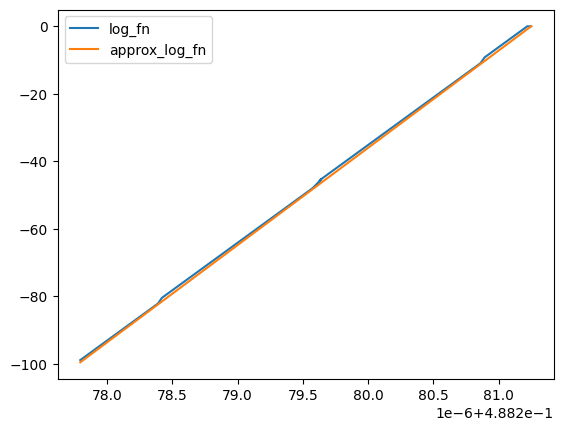

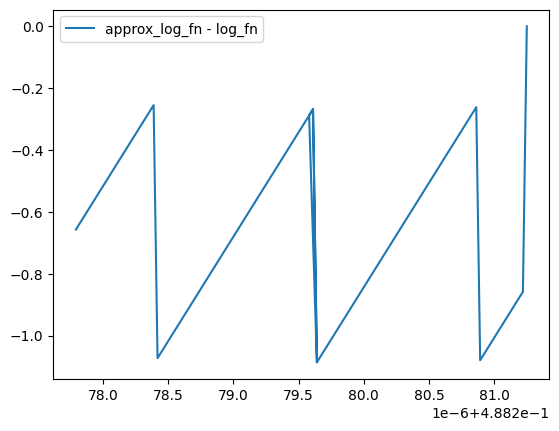

In [43]:
# a = 9.222275733947754
# b = 2.5610644817352295
# n = 14067711
# x1 = 0.447265625
# c = -7033855.5
# rad = -1.2717509889625944e-07


a = 9.222275733947754
b = 6.459555149078369
n = 14067711
x1 = 0.48828125
c = -7033855.5
rad = -3.470935610039305e-07
debug = True


mu = b / a
center = mu / 2
dist = jnp.sqrt(mu**2 + 4 * n / a) / 2
global_max = center + dist
global_in_range = global_max <= x1
if debug:
    print(f"{global_max=}, {global_in_range=}")
max_pt = jnp.minimum(global_max, x1)
# get approximation stuff
log_fn = log_fn_rel_factory(a, b, n, max_pt)
dlog_fn = dlog_fn_factory(a, b, n)
d2log_fn = d2log_fn_factory(a, b, n)
f0 = log_fn(max_pt)
f1 = dlog_fn(max_pt)
f2 = d2log_fn(max_pt)
approx_log_fn = lambda x: f0 + f1 * (x - max_pt) + 1/2 * f2 * (x - max_pt)**2

xs = jnp.linspace(x1 + 10 * rad, x1, 1000)
plt.plot(xs, log_fn(xs), label='log_fn')
plt.plot(xs, approx_log_fn(xs), label='approx_log_fn')
plt.legend()
plt.show()


xs = jnp.linspace(x1 + 10 * rad, x1, 1000)
plt.plot(xs, approx_log_fn(xs) - log_fn(xs), label='approx_log_fn - log_fn')
plt.legend()
plt.show()


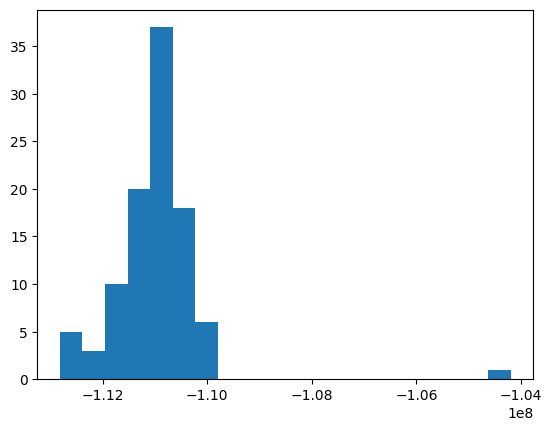

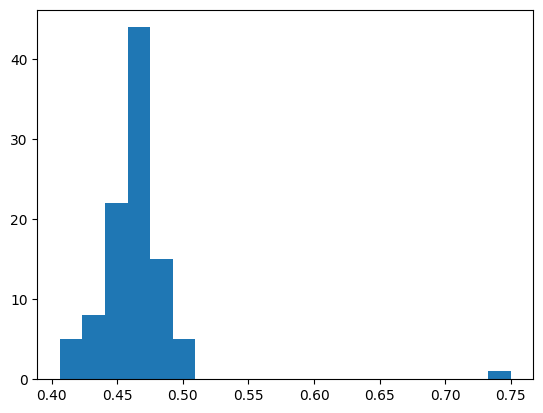

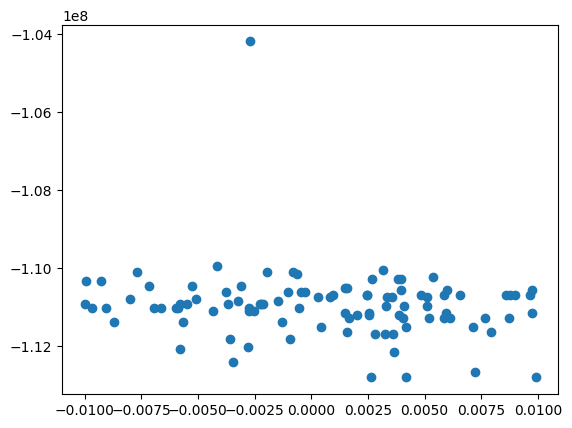

In [27]:
plt.hist(RESULTS['naive'].estimates, bins=20)
plt.show()

plt.hist(RESULTS['naive'].mults, bins=20)
plt.show()

plt.scatter((RESULTS['naive'].deltas - CUTOFF) / CUTOFF, RESULTS['naive'].estimates)
plt.show()


### Cutoff scan

In [28]:
logspace(1e-3, 1e3, 7)

Array([1.00000005e-03, 9.99999978e-03, 1.00000024e-01, 1.00000000e+00,
       1.00000000e+01, 1.00000000e+02, 1.00000000e+03], dtype=float32)

In [30]:
from tqdm import tqdm

In [62]:
result_size = 30
cutoffs = logspace(1e-8, 1e1, 10)

for i, cutoff in tqdm(enumerate(cutoffs)):
    RESULTS[f"cutoff_{i}"] = get_estimates_vectorized_gauss(result_size, 
                                                  batch_size=1,
                                                  sigma=sigma_params,
                                                  fn=kl_fn, 
                                                  params=trained_params_j, 
                                                  cutoff=cutoff,
                                                  tol=100., #0.1,
                                                  debug=False,
                                                  torch_model=True,
                                                 )


0it [00:00, ?it/s]

10it [06:53, 41.32s/it]


In [42]:
model_dim = trained_params_j.shape[0]

In [76]:
RESULTS['cutoff_3'].estimates.shape


(30,)

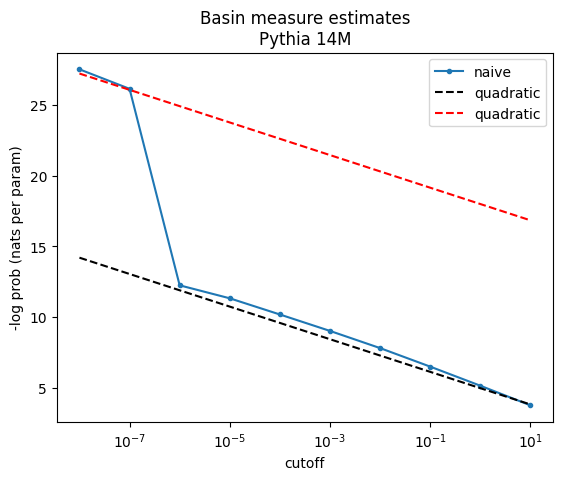

In [80]:
aggs = [aggregate(RESULTS[f"cutoff_{i}"].estimates) for i in range(len(cutoffs))]

plt.plot(cutoffs, -jnp.array(aggs) / model_dim, '.-', label='naive')
plt.plot(cutoffs, -1 / 2 * (jnp.log(cutoffs) - 10), 'k--', label='quadratic')
plt.plot(cutoffs, -1 / 2 * (jnp.log(cutoffs) - 36), 'r--', label='quadratic')
plt.xscale('log')
plt.legend()
plt.xlabel('cutoff')
plt.ylabel('-log prob (nats per param)')
plt.title('Basin measure estimates\nPythia 14M')
plt.show()


### Checkpoint scan

In [42]:
# get list of revisions from HuggingFace
# (they're Git branches)
from huggingface_hub import list_repo_refs
branches = list_repo_refs("EleutherAI/pythia-14m").branches

branch_names = [b.name for b in branches]
branch_names = [b for b in branch_names if b.startswith("step")]
checkpoint_steps = [int(b.split("step")[1]) for b in branch_names]
checkpoint_steps = sorted(checkpoint_steps)


In [43]:
checkpoint_steps

[0,
 1,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 256,
 512,
 1000,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 10000,
 11000,
 12000,
 13000,
 14000,
 15000,
 16000,
 17000,
 18000,
 19000,
 20000,
 21000,
 22000,
 23000,
 24000,
 25000,
 26000,
 27000,
 28000,
 29000,
 30000,
 31000,
 32000,
 33000,
 34000,
 35000,
 36000,
 37000,
 38000,
 39000,
 40000,
 41000,
 42000,
 43000,
 44000,
 45000,
 46000,
 47000,
 48000,
 49000,
 50000,
 51000,
 52000,
 53000,
 54000,
 55000,
 56000,
 57000,
 58000,
 59000,
 60000,
 61000,
 62000,
 63000,
 64000,
 65000,
 66000,
 67000,
 68000,
 69000,
 70000,
 71000,
 72000,
 73000,
 74000,
 75000,
 76000,
 77000,
 78000,
 79000,
 80000,
 81000,
 82000,
 83000,
 84000,
 85000,
 86000,
 87000,
 88000,
 89000,
 90000,
 91000,
 92000,
 93000,
 94000,
 95000,
 96000,
 97000,
 98000,
 99000,
 100000,
 101000,
 102000,
 103000,
 104000,
 105000,
 106000,
 107000,
 108000,
 109000,
 110000,
 111000,
 112000,
 113000,
 114000,
 115000,
 116000,
 117000,
 1

In [36]:
commits

[GitCommitInfo(commit_id='f33025648652797a390d8c54835273845b437161', authors=['stellaathena', 'SFconvertbot'], created_at=datetime.datetime(2023, 7, 26, 17, 38, 10, tzinfo=datetime.timezone.utc), title='Adding `safetensors` variant of this model (#1)', message='\n\n\n- Adding `safetensors` variant of this model (a006807133d0c2dc4c0952d7593ffaa53a2565b4)\n\n\nCo-authored-by: Safetensors convertbot <SFconvertbot@users.noreply.huggingface.co>\n', formatted_title=None, formatted_message=None),
 GitCommitInfo(commit_id='c97ed858d295c7a69a65a56ff8083111dfff796f', authors=['hails'], created_at=datetime.datetime(2023, 7, 19, 13, 57, 59, tzinfo=datetime.timezone.utc), title='Upload tokenizer.json', message='', formatted_title=None, formatted_message=None),
 GitCommitInfo(commit_id='e893043be8e5214861a83e4f283993371aab8228', authors=['hails'], created_at=datetime.datetime(2023, 7, 19, 13, 57, 59, tzinfo=datetime.timezone.utc), title='Upload special_tokens_map.json', message='', formatted_title=N

In [16]:
def get_checkpoint_params(revision):
    model_chkpt = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-14m", revision=revision).to("cuda")
    params_chkpt_t = torch.nn.utils.parameters_to_vector(model_chkpt.parameters()).detach()
    params_chkpt_j = jax.dlpack.from_dlpack(params_chkpt_t)
    return params_chkpt_j


testing:

In [ ]:

params_142k = get_checkpoint_params("step142000")
params_100k = get_checkpoint_params("step100000")

kl_fn_142k = make_kl_fn_params(params_142k, apply_fn, X_val_t, l2_reg=0.)
kl_fn_100k = make_kl_fn_params(params_100k, apply_fn, X_val_t, l2_reg=0.)

print(kl_fn_142k(trained_params_j, 0.))
print(kl_fn_100k(trained_params_j, 0.))


/home/adam/.conda/envs/jax311/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/adam/.conda/envs/jax311/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this 

In [24]:
# RESULTS = {}
# RESULTS['chkpts'] = {}

In [27]:
model_dim = trained_params_j.shape[0]

In [44]:
CUTOFF = 1e-2
RESULT_SIZE = 10
chkpts = [c for c in checkpoint_steps if c < 1000] + [
          1000, 2000, 5000, 
          10000, 20000, 50000, 
          100000, 110000, 120000, 130000, 140000, 143000,
         ]

for chkpt in tqdm(chkpts):
    params_chkpt = get_checkpoint_params(f"step{chkpt}")
    kl_fn_chkpt = make_kl_fn_params(params_chkpt, apply_fn, X_val_t, l2_reg=0.)
    RESULTS['chkpts'][chkpt] = get_estimates_vectorized_gauss(RESULT_SIZE, 
                                                  batch_size=1,
                                                  sigma=sigma_params,
                                                  fn=kl_fn_chkpt, 
                                                  params=trained_params_j, 
                                                  cutoff=CUTOFF,
                                                  tol=100., #0.1,
                                                  debug=False,
                                                  torch_model=True,
                                                 )


  0%|          | 0/23 [00:00<?, ?it/s]

/home/adam/.conda/envs/jax311/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/adam/.conda/envs/jax311/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  4%|▍         | 1/23 [00:40<14:50, 40.48s/it]/home/adam/.conda/envs/jax311/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called.

In [48]:
RESULTS['chkpts'].keys()

dict_keys([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 10000, 20000, 50000, 100000, 110000, 120000, 130000, 140000, 143000])

In [53]:
# save RESULTS somewhere handy
with open("../data/RESULTS.pkl", "wb") as f:
    pickle.dump(RESULTS, f)


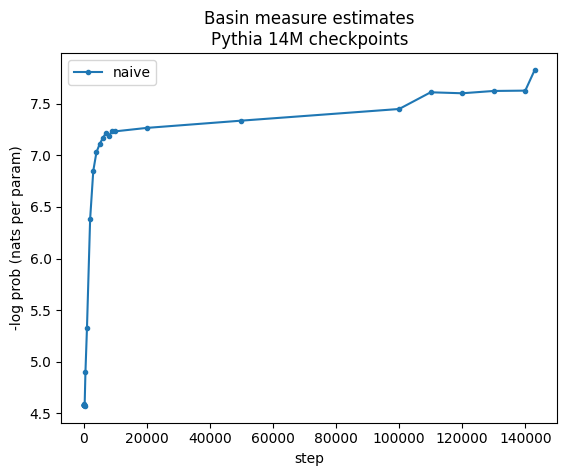

In [52]:
chkpts = sorted(RESULTS['chkpts'].keys())

aggs = [aggregate(RESULTS['chkpts'][chkpt].estimates) for chkpt in chkpts]

plt.plot(chkpts, -jnp.array(aggs) / model_dim, '.-', label='naive')
plt.legend()
plt.xlabel('step')
plt.ylabel('-log prob (nats per param)')
#plt.xscale('log')
# plt.yscale('log')
plt.title('Basin measure estimates\nPythia 14M checkpoints')
plt.show()


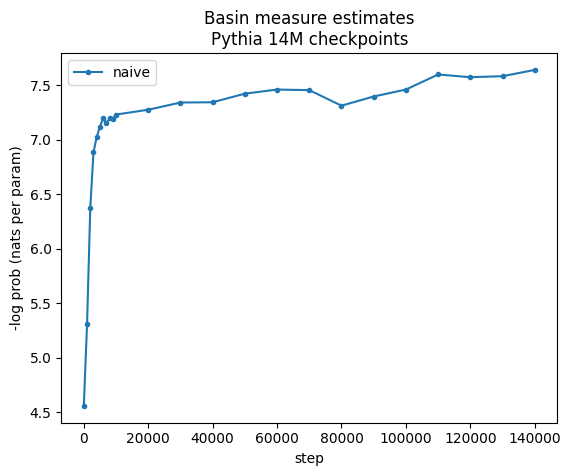

In [ ]:
chkpts = sorted(RESULTS['chkpts'].keys())

aggs = [aggregate(RESULTS['chkpts'][chkpt].estimates) for chkpt in chkpts]

plt.plot(chkpts, -jnp.array(aggs) / model_dim, '.-', label='naive')
plt.legend()
plt.xlabel('step')
plt.ylabel('-log prob (nats per param)')
plt.title('Basin measure estimates\nPythia 14M checkpoints')
plt.show()


# (Memory management)

## Torch

In [ ]:
def get_tensor_memory_usage():
    # Force garbage collection first
    gc.collect()
    torch.cuda.empty_cache()
    
    # Get all tensors in memory)
    tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                tensors.append((obj.shape, obj.dtype, obj.element_size() * obj.nelement() / 1024**2))
        except:
            pass
    
    # Sort by memory usage (MB)
    return sorted(tensors, key=lambda x: x[2], reverse=True)

In [ ]:

# Print top 10 tensors by memory usage
for shape, dtype, size_mb in get_tensor_memory_usage()[:30]:
    print(f"Shape: {shape}, Dtype: {dtype}, Size: {size_mb:.2f} MB")

Shape: torch.Size([100, 1024, 50304]), Dtype: torch.float32, Size: 19650.00 MB
Shape: torch.Size([14067712]), Dtype: torch.float32, Size: 53.66 MB
Shape: torch.Size([50304, 128]), Dtype: torch.float32, Size: 24.56 MB
Shape: torch.Size([50304, 128]), Dtype: torch.float32, Size: 24.56 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Shape: torch.Size([100, 1024]), Dtype: torch.int64, Size: 0.78 MB
Shape: torch.Size([512, 128]), Dtype: torch.float32, Size: 0.25 MB
Shape: torch.Size([128, 512]), Dtype: torch.float32, Size: 0.25 MB
Shape: torch.Size([512, 128]), Dtype: torch.float32, Size: 0.25 MB
Shape: torch.S

/opt/conda/envs/jax311/lib/python3.11/site-packages/torch/__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [ ]:
# total memory usage by Torch
print(f"Total memory usage by Torch: {sum(size_mb for _, _, size_mb in get_tensor_memory_usage())} MB")

Total memory usage by Torch: 19782.109504699707 MB


### Torch w/ Python

In [ ]:
def get_tensor_memory_usage():
    # Force garbage collection first
   (10, 1024, 50304)n gc.get_referrers(obj):
                    if isinstance(referrer, dict):
                        # If it's in a dictionary (like globals() or locals()),
                        # find variable names pointing to this tensor
                        for var_name, var_val in referrer.items():
                            if var_val is obj:
                                referrers.append(var_name)
                    
                tensor_info.append({
                    'shape': obj.shape,
                    'dtype': obj.dtype,
                    'size_mb': obj.element_size() * obj.nelement() / 1024**2,
                    'referrers': referrers
                })
        except:
            pass
    
    # Sort by memory usage (MB)
    return sorted(tensor_info, key=lambda x: x['size_mb'], reverse=True)

# Print top tensors by memory usage with their referrers
for info in get_tensor_memory_usage()[:30]:
    print(f"Shape: {info['shape']}, Dtype: {info['dtype']}, Size: {info['size_mb']:.2f} MB")
    if info['referrers']:
        print(f"Referenced by: {info['referrers']}")
    print()

/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/torch/__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


Shape: torch.Size([14067712]), Dtype: torch.float32, Size: 53.66 MB
Referenced by: ['trained_params_t']

Shape: torch.Size([50304, 128]), Dtype: torch.float32, Size: 24.56 MB
Referenced by: ['weight']

Shape: torch.Size([50304, 128]), Dtype: torch.float32, Size: 24.56 MB
Referenced by: ['weight']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([1, 1, 2048, 2048]), Dtype: torch.bool, Size: 4.00 MB
Referenced by: ['bias']

Shape: torch.Size([512, 128]), Dtype: torch.float32, Size: 0.25 MB
Referenced by: ['weight']

Shape: torch.Size([128, 5

## JAX

In [79]:
def get_jax_memory_usage():
    # Force garbage collection
    gc.collect()
    
    # Get live arrays from JAX
    live_arrays = jax.live_arrays()
    
    # Calculate size and sort by memory usage
    array_sizes = []
    for arr in live_arrays:
        try:
            shape = arr.shape
            dtype = arr.dtype
            size_mb = arr.size * arr.dtype.itemsize / (1024 * 1024)  # Convert to MB
            array_sizes.append((shape, dtype, size_mb))
        except:
            pass
    
    # Sort by size
    array_sizes.sort(key=lambda x: x[2], reverse=True)
    
    # Print top arrays
    print("\nLargest JAX Arrays:")
    for shape, dtype, size_mb in array_sizes[:30]:
        print(f"Shape: {shape}, Dtype: {dtype}, Size: {size_mb:.2f} MB")
    
    total_mb = sum(size for _, _, size in array_sizes)
    print(f"\nTotal JAX Memory Usage: {total_mb:.2f} MB")

# Get current memory usage
get_jax_memory_usage()


Largest JAX Arrays:
Shape: (30, 1024, 50304), Dtype: float32, Size: 5895.00 MB
Shape: (30, 1024, 50304), Dtype: float32, Size: 5895.00 MB
Shape: (30, 1024, 50304), Dtype: float32, Size: 5895.00 MB
Shape: (30, 1024, 50304), Dtype: float32, Size: 5895.00 MB
Shape: (10, 1024, 50304), Dtype: float32, Size: 1965.00 MB
Shape: (10, 1024, 50304), Dtype: float32, Size: 1965.00 MB
Shape: (30, 1024, 50304), Dtype: bool, Size: 1473.75 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (14067712,), Dtype: float32, Size: 53.66 MB
Shape: (30, 1024), Dtype: int32, Size: 0.12 MB
Shape: (10, 1024), Dtype: int32, Size: 0.04 MB
Shape: (10, 1024), Dtype: int32, Size: 0.04 MB
Shape: (10, 1024), D

In [91]:
def get_jax_memory_usage():
    # Force garbage collection
    gc.collect()
    
    # Get live arrays from JAX
    live_arrays = jax.live_arrays()
    
    # Calculate size and track references
    array_info = []
    for arr in live_arrays:
        try:
            # Find all referrers to this array
            referrers = []
            for referrer in gc.get_referrers(arr):
                if isinstance(referrer, dict):
                    # If it's in a dictionary (like globals() or locals()),
                    # find variable names pointing to this array
                    for var_name, var_val in referrer.items():
                        if var_val is arr:
                            referrers.append(var_name)
            
            shape = arr.shape
            dtype = arr.dtype
            size_mb = arr.size * arr.dtype.itemsize / (1024 * 1024)  # Convert to MB
            array_info.append({
                'shape': shape,
                'dtype': dtype,
                'size_mb': size_mb,
                'referrers': referrers
            })
        except:
            pass
    
    # Sort by size
    array_info.sort(key=lambda x: x['size_mb'], reverse=True)
    
    # Print top arrays
    print("\nLargest JAX Arrays:")
    for info in array_info[:30]:
        print(f"Shape: {info['shape']}, Dtype: {info['dtype']}, Size: {info['size_mb']:.2f} MB")
        if info['referrers']:
            print(f"Referenced by: {info['referrers']}")
        print()
    
    total_mb = sum(info['size_mb'] for info in array_info)
    print(f"\nTotal JAX Memory Usage: {total_mb:.2f} MB")

In [101]:
def get_jax_memory_usage():
    gc.collect()
    live_arrays = jax.live_arrays()
    
    array_info = []
    for arr in live_arrays:
        try:
            referrers = []
            for referrer in gc.get_referrers(arr):
                if isinstance(referrer, dict):
                    var_names = [name for name, val in referrer.items() if val is arr]
                    if var_names:
                        dict_referrers = gc.get_referrers(referrer)
                        for r in dict_referrers:
                            if isinstance(r, types.FrameType):
                                # Get frame info
                                frame_info = {
                                    'function': r.f_code.co_name,
                                    'filename': r.f_code.co_filename,
                                    'lineno': r.f_lineno
                                }
                                referrers.append({
                                    'names': var_names,
                                    'dict_type': str(type(referrer)),
                                    'frame': frame_info
                                })
            
            shape = arr.shape
            dtype = arr.dtype
            size_mb = arr.size * arr.dtype.itemsize / (1024 * 1024)
            array_info.append({
                'shape': shape,
                'dtype': dtype,
                'size_mb': size_mb,
                'referrers': referrers
            })
        except:
            pass
    
    array_info.sort(key=lambda x: x['size_mb'], reverse=True)
    
    print("\nLargest JAX Arrays:")
    for info in array_info[:30]:
        print(f"Shape: {info['shape']}, Dtype: {info['dtype']}, Size: {info['size_mb']:.2f} MB")
        if info['referrers']:
            for ref in info['referrers']:
                print(f"Referenced as: {ref['names']}")
                if 'frame' in ref:
                    print(f"In function: {ref['frame']['function']}")
                    print(f"File: {ref['frame']['filename']}:{ref['frame']['lineno']}")
        print()

In [97]:
str(type([]))

"<class 'list'>"

In [102]:

# Get current memory usage
get_jax_memory_usage()


Largest JAX Arrays:
Shape: (30, 1024, 50304), Dtype: float32, Size: 5895.00 MB

Shape: (10, 1024, 50304), Dtype: float32, Size: 1965.00 MB

Shape: (10, 1024, 50304), Dtype: float32, Size: 1965.00 MB

Shape: (14067712,), Dtype: float32, Size: 53.66 MB

Shape: (14067712,), Dtype: float32, Size: 53.66 MB

Shape: (14067712,), Dtype: float32, Size: 53.66 MB

Shape: (14067712,), Dtype: float32, Size: 53.66 MB

Shape: (14067712,), Dtype: float32, Size: 53.66 MB

Shape: (10, 1024), Dtype: int32, Size: 0.04 MB

Shape: (10, 1024), Dtype: int32, Size: 0.04 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32, Size: 0.00 MB

Shape: (100,), Dtype: float32

In [81]:
def clear_memory():
    # Clear PyTorch cache
    gc.collect()
    torch.cuda.empty_cache()
    
    # Clear JAX cache
    jax.clear_caches()
    
    # Additional garbage collection
    gc.collect()

# Usage
clear_memory()